In [2]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
from DLScommonTools import *
import os
import pickle as pkl
from scipy import interpolate
import scipy as sp
set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2

store_labels = dict()
store_labels["cvar"] = {"density" : "$n_{u}\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}$"}
store_labels["crel"] = {"density" : "$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ /\ q_{\parallel0} (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_names =         {"density" : "$n_{u}\ /\ n_{u0}$",
                        "power" : "$q_{\parallel0}\ /\ q_{\parallel}$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_cnames =         {"density" : "$[n_{u}\ /\ n_{u0}]^{1}$",
                        "power" : "$[q_{\parallel0}\ /\ q_{\parallel}]^{5/7}$",
                        "impurity_frac" : "$[f_{z}\ /\ f_{z0}]^{0.5}$"}

# Read V10 balance file
- File is not supplied due to GitHub file size limit, contact mike.kryjak@york.ac.uk
- The field lines were extracted and saved to a pkl file you can use ("equilibrium.pkl")

In [3]:
# balance_path = os.path.join("STEPv10", "drsep0mm", "balance_v10.nc")
# eqb = dict()
# eqb["V10"] = dict()

# for side in ["iu", "ou"]: # Inner upper, outer upper.
#     eqb["V10"][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=2, resolution = 100)
    
# file_write(eqb, "equilibrium.pkl")

In [4]:
eqb = file_read("equilibrium.pkl")

# Run DLS

## DLS settings

In [5]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20, # Upstream density
    "cz0" : 0.02, # Impurity fraction
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncKallenbachAr, #impurity cooling function 
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


## Run

In [7]:
list_cvars = ["density", "power", "impurity_frac"]
list_designs = ["V10"]
hiq_multiplier = 220/100

store = dict()

for design in list_designs:
    store[design] = dict()
    print("Design {}...".format(design), end = "")
    
    for cvar in list_cvars:
        store[design][cvar] = dict()
        print(f"Variable {cvar}...", end = "")
    
        for side in ["iu","ou"]:
            print("Side {}...".format(side))

            d = eqb[design][side].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()
            constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 7)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
            
            if side == "iu":
                constants["qpllu0"] = 1e8
            elif side == "ou":
                constants["qpllu0"] = 1e9
            
            store[design][cvar][side] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = cvar)
        
example_results = copy.deepcopy(store)

Design V10...Variable density...Side iu...
Solving...0...4...6...8...9...9...10...Complete in 9.6 seconds
Side ou...
Solving...0...11...19...26...31...34...35...Complete in 8.9 seconds
Variable power...Side iu...
Solving...0...4...6...8...9...9...10...Complete in 12.7 seconds
Side ou...
Solving...0...11...19...26...31...34...35...Complete in 7.8 seconds
Variable impurity_frac...Side iu...
Solving...0...4...6...8...9...9...10...Complete in 7.1 seconds
Side ou...
Solving...0...11...19...26...31...34...35...Complete in 7.6 seconds


In [59]:
file_write(example_results, "example_results.pkl")

In [60]:
example_results = file_read("example_results.pkl")

## Plot relative control variable for power, density and impurity fraction against pol front location

Text(0.5, 1.0, 'Inner divertor')

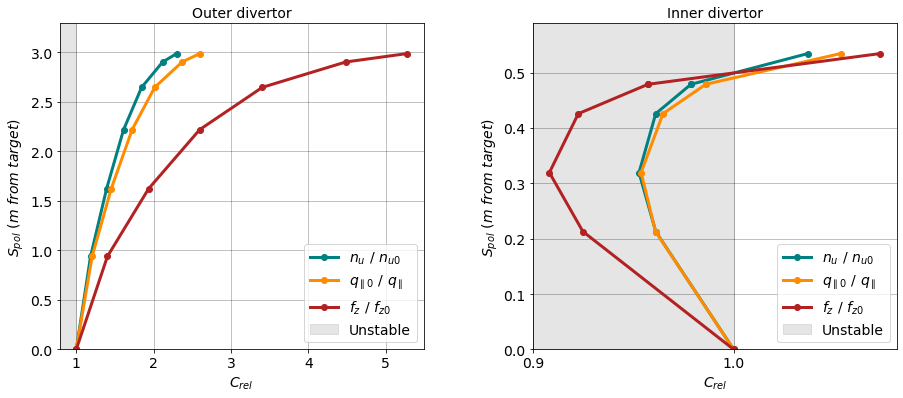

In [9]:
colors = mike_cmap(3)

design = "V10"
x = "SpolPlot"
basis = "crel"

fig, axes = plt.subplots(1,2, figsize = (15,6))
plt.subplots_adjust(hspace=.25, wspace = 0.3)

ax = axes[0]
styles = ["solid", "solid", "solid"]
for k, cvar in enumerate(list_cvars):
    for i, side in enumerate(["ou", "iu"]):
        o = example_results[design][cvar][side].copy()

        if cvar == "power":
            crel = 1/o["crel"]
        else:
            crel = o["crel"]
            
        axes[i].plot(crel, o[x],  marker = "o", label = store_names[cvar], markersize = 6, linewidth = 3, ls = styles[i], color = colors[k])

ylims = axes[1].get_ylim()
axes[1].set_ylim(0,ylims[1])
axes[0].xaxis.set_major_locator(MultipleLocator(1))
axes[1].xaxis.set_major_locator(MultipleLocator(0.1))

for ax in axes:
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    ylims_new = (0,ylims[1]+ylims[1]*0.05)
    ax.set_ylim(ylims_new)
    ax.fill_between([xlims[0],1],0,ylims_new[1], color = "grey", alpha = 0.2, label = "Unstable")   
    ax.set_xlim(xlims)
    
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$C_{rel}$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.legend()

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")
